In [1]:
#import packages
import numpy as np
import scipy.sparse as sps
import sys
import pandas as pd
import os
import operator
import matplotlib.pyplot as plt

In [2]:
#read data
data=pd.read_csv('attribution_allocation_student_data.csv')
data2=pd.read_csv('channel_spend_student_data.csv')

### data preprocessing

In [3]:
#filter out those who didn't convert
check=data.loc[data['convert_TF']==True]
check

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier
0,True,referral,referral,referral,email,NaN,1
1,True,referral,display,display,email,NaN,1
2,True,email,display,referral,NaN,NaN,1
3,True,referral,referral,email,NaN,NaN,1
4,True,social,referral,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...
60648,True,referral,referral,referral,NaN,NaN,3
60649,True,display,referral,NaN,NaN,NaN,3
68103,True,organic_search,referral,paid_search,NaN,NaN,3
68104,True,organic_search,display,NaN,NaN,NaN,3


In [4]:
tier=check['tier']
conv=check['convert_TF']
check2=check.drop('tier',axis=1)
check2=check2.drop('convert_TF',axis=1)
#convert to long data frame
check2=check2.stack()
check2=pd.DataFrame(check2)
check2.reset_index(level=1, inplace=True)
check2['tier']=tier
check2['convert_TF']=conv

In [5]:
check2

,level_1,0,tier,convert_TF
0,touch1,referral,1,True
0,touch2,referral,1,True
0,touch3,referral,1,True
0,touch4,email,1,True
1,touch1,referral,1,True
...,...,...,...,...
68103,touch2,referral,3,True
68103,touch3,paid_search,3,True
68104,touch1,organic_search,3,True
68104,touch2,display,3,True


In [6]:
#rename columns
check2.rename({'level_1':'touch',0:'type'},axis=1,inplace=True)
check2=check2.reset_index()
#find paths of users
df_paths = check2.groupby('index')['type'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"type": "path"})
#add tier back to dataframe
df_paths=df_paths.set_index(df_paths['index'])
df_paths['tier']=tier
df_paths

,index,path,tier
index,,,
0,0,"[referral, referral, referral, email]",1
1,1,"[referral, display, display, email]",1
2,2,"[email, display, referral]",1
3,3,"[referral, referral, email]",1
4,4,"[social, referral]",1
...,...,...,...
60648,60648,"[referral, referral, referral]",3
60649,60649,"[display, referral]",3
68103,68103,"[organic_search, referral, paid_search]",3


In [7]:
dic={1:5000,2:10000,3:15000}
df_paths['spend']=df_paths['tier'].apply(lambda x:dic[x])
df_paths.drop('index',axis=1,inplace=True)
df_paths

,path,tier,spend
index,,,
0,"[referral, referral, referral, email]",1,5000
1,"[referral, display, display, email]",1,5000
2,"[email, display, referral]",1,5000
3,"[referral, referral, email]",1,5000
4,"[social, referral]",1,5000
...,...,...,...
60648,"[referral, referral, referral]",3,15000
60649,"[display, referral]",3,15000
68103,"[organic_search, referral, paid_search]",3,15000


In [8]:
#separate by tiers
t1=df_paths.loc[check['tier']==1]
t2=df_paths.loc[check['tier']==2]
t3=df_paths.loc[check['tier']==3]
t2

,path,tier,spend
index,,,
11354,"[display, referral, referral, email]",2,10000
11355,"[referral, referral, email]",2,10000
11356,"[email, social, social]",2,10000
11357,"[social, email]",2,10000
11358,"[email, referral, email]",2,10000
...,...,...,...
26941,"[referral, email]",2,10000
26942,"[referral, referral, referral]",2,10000
34041,"[organic_search, referral, referral]",2,10000


In [75]:
len(t1)

2824

In [76]:
len(t2)

4892

In [78]:
len(t3)

6063

# Question 1: Attribution

## 1.1: 3 methods for allocation

In [9]:
#last touch
#define function

def get_cac(df_paths):
    lt={'referral':[],'social':[],'display':[],'paid_search':[],'email':[],'direct':[],'organic_search':[]}
    ft={'referral':[],'social':[],'display':[],'paid_search':[],'email':[],'direct':[],'organic_search':[]}
    lr={'referral':[],'social':[],'display':[],'paid_search':[],'email':[],'direct':[],'organic_search':[]}





    dic2={1:5000,2:10000,3:15000}
    for i in df_paths.index:
        spend=df_paths.loc[i]['spend']
        last_touch=df_paths.loc[i]['path'][-1]
        first_touch=df_paths.loc[i]['path'][0]
        paths=df_paths.loc[i]['path']
        for i in paths:
            #lr[i].append(spend/len(paths))
            lr[i].append(1/len(paths))
       # lt[last_touch].append(spend)
        #ft[first_touch].append(spend)
        lt[last_touch].append(1)
        ft[first_touch].append(1)
    return(lt,ft,lr)


In [10]:
lt,ft,lr=get_cac(df_paths)

In [11]:
n=len(df_paths)
#attribution using last touch, linear and first touch
att_lt={}
att_lr={}
att_ft={}
for i in lt.keys():
    #print(sum(lt[i])/n)
    att_lt[i]=sum(lt[i])/n
att_lt

for i in lr.keys():
    att_lr[i]=sum(lr[i])/n

for i in ft.keys():
    att_ft[i]=sum(ft[i])/n

In [12]:
att_lr

{'referral': 0.5416817862930523,
 'social': 0.16707913007716935,
 'display': 0.14583545008103832,
 'paid_search': 0.051155139463435084,
 'email': 0.09253937150736677,
 'direct': 0.0005370491327382249,
 'organic_search': 0.0011720734450976127}

In [55]:
att_ft

{'referral': 0.5439436824152696,
 'social': 0.1654691922490747,
 'display': 0.14739821467450467,
 'paid_search': 0.04847957036069381,
 'email': 0.09318528195079469,
 'direct': 0.00043544524276072284,
 'organic_search': 0.001088613106901807}

In [74]:
att_lt

{'referral': 0.43646128166049786,
 'social': 0.21481965309528994,
 'display': 0.16634008273459613,
 'paid_search': 0.07286450395529429,
 'email': 0.10820814282603962,
 'direct': 0.00050801944988751,
 'organic_search': 0.0007983162783946585}

## 1.2: Average CAC for each channel

In [56]:
#calculate average cac(cost is 6000)
dic_ft={}
dic_lr={}
dic_lt={}
for i in att_ft.keys():
    new_cust=att_ft[i]*n
    if i not in ['direct','organic_search']:
        cost=6000  #what is cost?
    else:
        cost=0
    cac=cost/new_cust
    dic_ft[i]=cac
    
for i in att_lt.keys():
    new_cust=att_lt[i]*n
    if i not in ['direct','organic_search']:
        cost=6000  #what is cost?
    else:
        cost=0
    cac=cost/new_cust
    dic_lt[i]=cac
    
for i in att_lr.keys():
    new_cust=att_lr[i]*n
    if i not in ['direct','organic_search']:
        cost=6000  #what is cost?
    else:
        cost=0
    cac=cost/new_cust
    dic_lr[i]=cac

In [57]:
dic_ft

{'referral': 0.800533689126084,
 'social': 2.6315789473684212,
 'display': 2.9542097488921715,
 'paid_search': 8.982035928143713,
 'email': 4.672897196261682,
 'direct': 0.0,
 'organic_search': 0.0}

In [58]:
dic_lt

{'referral': 0.9976720984369803,
 'social': 2.027027027027027,
 'display': 2.6178010471204187,
 'paid_search': 5.9760956175298805,
 'email': 4.0241448692152915,
 'direct': 0.0,
 'organic_search': 0.0}

In [59]:
dic_lr

{'referral': 0.8038764709824394,
 'social': 2.6062216301916488,
 'display': 2.9858668966890645,
 'paid_search': 8.512248179324631,
 'email': 4.705513293075028,
 'direct': 0.0,
 'organic_search': 0.0}

<Figure size 432x288 with 0 Axes>

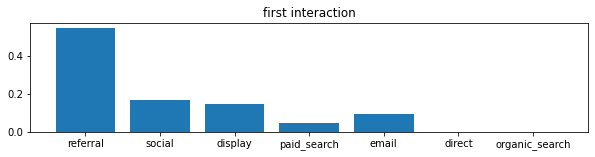

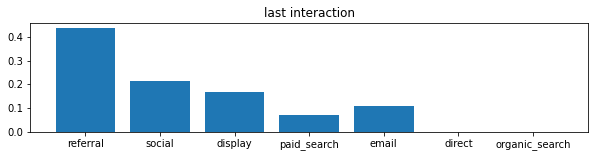

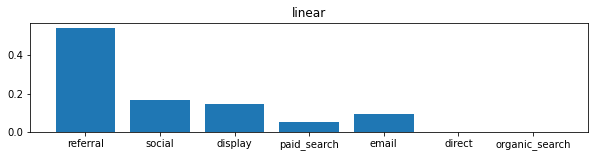

In [48]:
#plot conversion results
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

plt.figure(1)
figure(figsize=(10,2))
plt.xticks(range(7))
plt.title('first interaction')
plt.bar(att_ft.keys(),att_ft.values())


plt.figure(2)
figure(figsize=(10,2))
plt.xticks(range(7))
plt.title('last interaction')
plt.bar(att_lt.keys(),att_lt.values())


plt.figure(3)
figure(figsize=(10,2))
plt.xticks(range(7))
plt.title('linear')
plt.bar(att_lr.keys(),att_lr.values())

plt.show()


<Figure size 432x288 with 0 Axes>

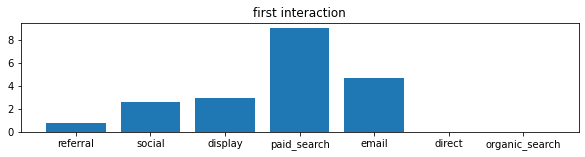

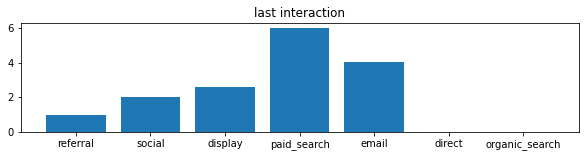

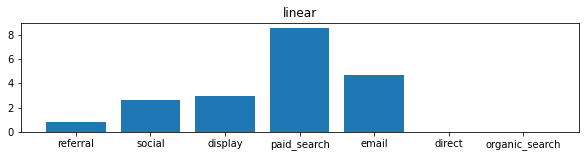

In [60]:
#plot average cac
plt.figure(1)
figure(figsize=(10,2))
plt.xticks(range(7))
plt.title('first interaction')
plt.bar(dic_ft.keys(),dic_ft.values())


plt.figure(2)
figure(figsize=(10,2))
plt.xticks(range(7))
plt.title('last interaction')
plt.bar(dic_lt.keys(),dic_lt.values())


plt.figure(3)
figure(figsize=(10,2))
plt.xticks(range(7))
plt.title('linear')
plt.bar(dic_lr.keys(),dic_lr.values())

plt.show()


# Question 2: Allocation

## 2.1: choose linear for marginal CAC

In [61]:
#marginal cac:
lt1,ft1,lr1=get_cac(t1)
lt2,ft2,lr2=get_cac(t2)
lt3,ft3,lr3=get_cac(t3)


In [21]:
lr1

{'referral': [0.25,
  0.25,
  0.25,
  0.25,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.25,
  0.25,
  0.25,
  1.0,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.25,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.5,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.2,
  0.2,
  0.2,
  0.5,
  0.25,
  0.25,
  0.3333333333333333,
  0.3333333333333333,
  0.25,
  0.25,
  0.25,
  0.25,
  0.25,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.25,
  0.25,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.25,
  0.25,
  0.5,
  0.25,
  0.25,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  1.0,
  0.5,
  0.3333333333333333,
  0.333333

In [62]:
#calculate attribution by tiers
att_lr1={}
att_lr2={}
att_lr3={}

for i in lr1.keys():
    #print(sum(lt[i])/n)
    att_lr1[i]=sum(lr1[i])

for i in lr2.keys():
    att_lr2[i]=sum(lr2[i])

for i in lr3.keys():
    att_lr3[i]=sum(lr3[i])
att_lr2

{'referral': 2656.683333333344,
 'social': 822.3666666666782,
 'display': 724.0833333333404,
 'paid_search': 237.81666666666717,
 'email': 442.51666666666245,
 'direct': 2.0666666666666664,
 'organic_search': 6.466666666666666}

In [63]:
att_lr3['social']-att_lr2['social']

172.8666666666769

In [64]:
#calculaet marginal cac
marg_cac1={}
marg_cac2={}
marg_cac3={}
for i in att_lr1.keys():
    new_cust=att_lr1[i]
    if i not in ['direct','organic_search']:
        cost=1000  #what is cost?
    else:
        cost=0
    
    cac=cost/new_cust
    marg_cac1[i]=cac
    #print(cost,new_cust)
    #print(i,cac)

for i in att_lr2.keys():
    new_cust=att_lr2[i]-att_lr1[i]
    if i not in ['direct','organic_search']:
        cost=1000  #what is cost?
    else:
        cost=0
    cac=cost/new_cust
    marg_cac2[i]=cac

    
for i in att_lr3.keys():
    new_cust=att_lr3[i]-att_lr2[i]
    if i not in ['direct','organic_search']:
        cost=1000  #what is cost?
    else:
        cost=0
    cac=cost/new_cust
    marg_cac3[i]=cac


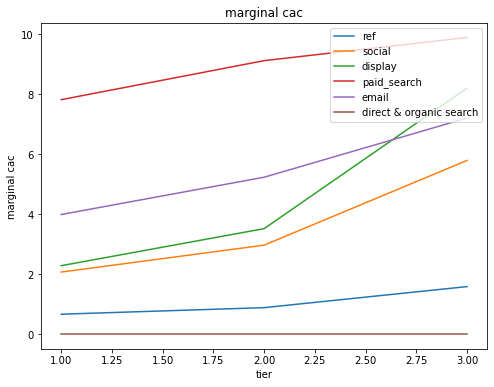

In [65]:
#plot marginal cac
figure(figsize=(8,6))
plt.title('marginal cac')
plt.xlabel('tier')
plt.ylabel('marginal cac')
plt.plot([1,2,3],[marg_cac1['referral'],marg_cac2['referral'],marg_cac3['referral']],label="ref")
plt.plot([1,2,3],[marg_cac1['social'],marg_cac2['social'],marg_cac3['social']],label="social")
plt.plot([1,2,3],[marg_cac1['display'],marg_cac2['display'],marg_cac3['display']],label="display")
plt.plot([1,2,3],[marg_cac1['paid_search'],marg_cac2['paid_search'],marg_cac3['paid_search']],label="paid_search")
plt.plot([1,2,3],[marg_cac1['email'],marg_cac2['email'],marg_cac3['email']],label="email")
plt.plot([1,2,3],[marg_cac1['direct'],marg_cac2['direct'],marg_cac3['direct']],label="direct & organic search")
plt.legend(loc="upper right")


plt.show()

In [66]:
mcac1_items = marg_cac1.items()
mcac1_list = list(mcac1_items)
df_mcac1 = pd.DataFrame(mcac1_list)

In [67]:
mcac2_items = marg_cac2.items()
mcac2_list = list(mcac2_items)
df_mcac2 = pd.DataFrame(mcac2_list)
mcac3_items = marg_cac3.items()
mcac3_list = list(mcac3_items)
df_mcac3 = pd.DataFrame(mcac3_list)

In [68]:
df1 = df_mcac1.merge(df_mcac2, how='inner',on=0)
df2 = df1.merge(df_mcac3,how='inner',on=0)

In [69]:
df2

,0,1_x,1_y,1
0,referral,0.659152,0.877514,1.578864
1,social,2.063629,2.960478,5.784805
2,display,2.276521,3.511030,8.194482
3,paid_search,7.809449,9.110234,9.883051
4,email,3.981949,5.225115,7.197697
5,direct,0.000000,0.000000,0.000000
6,organic_search,0.000000,0.000000,0.000000


In [70]:
df2.columns = ['channel','tier1','tier2','tier3']

In [71]:
df2

,channel,tier1,tier2,tier3
0,referral,0.659152,0.877514,1.578864
1,social,2.063629,2.960478,5.784805
2,display,2.276521,3.511030,8.194482
3,paid_search,7.809449,9.110234,9.883051
4,email,3.981949,5.225115,7.197697
5,direct,0.000000,0.000000,0.000000
6,organic_search,0.000000,0.000000,0.000000


In [72]:
df2['tier1'] = round(df2['tier1'],2)
df2['tier2'] = round(df2['tier2'],2)
df2['tier3'] = round(df2['tier3'],2)
df2['num_tier1'] = round(1000/df2['tier1'])
df2['num_tier2'] = round(1000/df2['tier2'])
df2['num_tier3'] = round(1000/df2['tier3'])

In [73]:
df2

,channel,tier1,tier2,tier3,num_tier1,num_tier2,num_tier3
0,referral,0.66,0.88,1.58,1515.0,1136.0,633.0
1,social,2.06,2.96,5.78,485.0,338.0,173.0
2,display,2.28,3.51,8.19,439.0,285.0,122.0
3,paid_search,7.81,9.11,9.88,128.0,110.0,101.0
4,email,3.98,5.23,7.20,251.0,191.0,139.0
5,direct,0.00,0.00,0.00,inf,inf,inf
6,organic_search,0.00,0.00,0.00,inf,inf,inf
